In [15]:
%pip install rembg imgaug
%pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\MSI PC\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\MSI PC\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from rembg import remove
import imgaug.augmenters as iaa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [22]:
def augment_data(base_dir, augmented_dir, classes, num_augmented_images_per_image):
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        augmented_class_dir = os.path.join(augmented_dir, cls)
        if not os.path.exists(augmented_class_dir):
            os.makedirs(augmented_class_dir)

        image_files = os.listdir(class_dir)

        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)

            # Perform augmentation
            for i in range(num_augmented_images_per_image):
                augmenters = iaa.Sequential([
                    iaa.Fliplr(0.5),  # Flip horizontal dengan probabilitas 50%
                    iaa.Flipud(0.5),  # Flip vertical dengan probabilitas 50%
                    iaa.Affine(scale=(0.8, 1.2)),  # Zooming
                    iaa.Multiply((0.8, 1.2)),  # Brightness
                    iaa.LinearContrast((0.75, 1.5))  # Contrast
                ])
                augmented_img = augmenters(image=img)

                # Save augmented image
                augmented_img_path = os.path.join(augmented_class_dir, f"{os.path.splitext(img_file)[0]}_aug_{i}.jpg")
                cv2.imwrite(augmented_img_path, augmented_img)

In [23]:
# Function to remove background
def remove_background(image_path):
    with open(image_path, 'rb') as img_file:
        input_image = img_file.read()
        output_image = remove(input_image)
    return cv2.imdecode(np.frombuffer(output_image, np.uint8), cv2.IMREAD_UNCHANGED)


In [24]:
# Function to segment the image
def segment_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

In [25]:
# Function to extract color histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [29]:
# Function to extract LBP features
def extract_lbp_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 1
    num_points = 8 * radius

    lbp = np.zeros_like(gray_image)
    for y in range(0, gray_image.shape[0] - radius):
        for x in range(0, gray_image.shape[1] - radius):
            center = gray_image[y, x]
            code = 0
            for dy, dx in [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]:
                code <<= 1
                code |= gray_image[y + dy, x + dx] > center
            lbp[y, x] = code

    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257), range=(0, 256))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [30]:
# Paths and classes
base_dir = 'E:\Kuliah\Semester_8\ComVis\Cat_Breed_Recognition\dataset'  # Double check this path
augmented_dir = 'E:\Kuliah\Semester_8\ComVis\Cat_Breed_Recognition\dataset_augmented'
classes = ['Persian', 'British shorthair', 'Anggora', 'Domestic', 'Calico', 'Tabby', 'Tuxedo']
num_augmented_images_per_image = 10

# Verify base directory exists
if not os.path.exists(base_dir):
    print(f"Error: Base directory '{base_dir}' not found.")
else:
    # Augment data
    augment_data(base_dir, augmented_dir, classes, num_augmented_images_per_image)

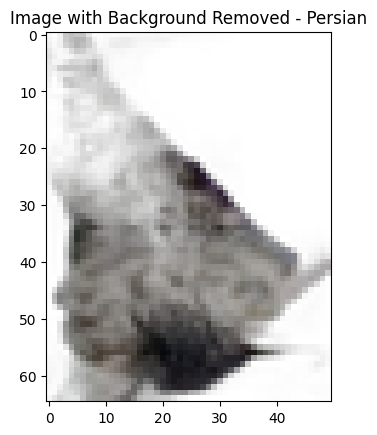

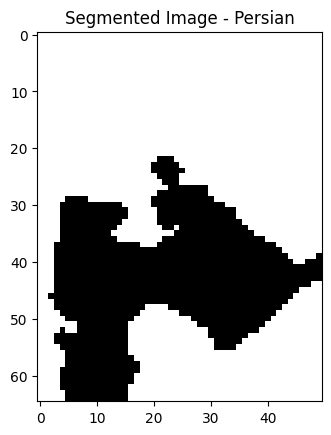

Color Histogram for Persian (first 10 values): [0.9476327  0.05159249 0.0751126  0.05842091 0.00379357 0.
 0.         0.         0.11760053 0.15705362]
LBP Features for Persian (first 10 values): [0.28830769 0.01753846 0.01753846 0.01015385 0.00984615 0.00215385
 0.01107692 0.01692308 0.008      0.00092308]


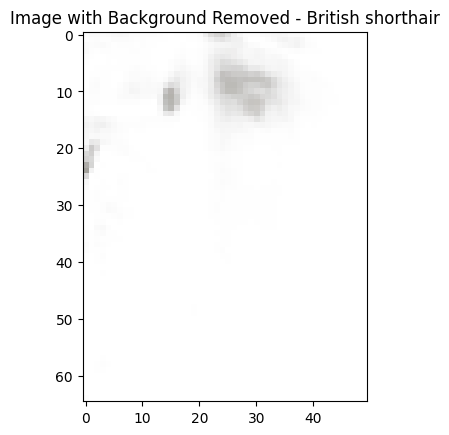

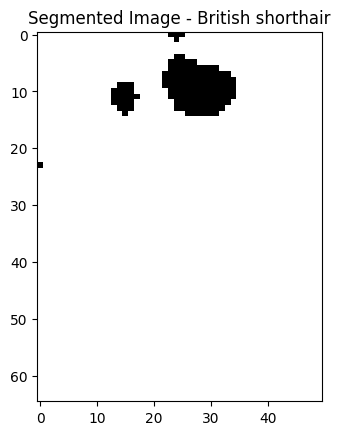

Color Histogram for British shorthair (first 10 values): [9.9756479e-01 3.7615566e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2945495e-02 1.2036981e-02]
LBP Features for British shorthair (first 10 values): [0.676      0.008      0.00923077 0.00707692 0.00461538 0.00092308
 0.00615385 0.012      0.004      0.        ]


In [31]:
# Collect features from up to 150 images in each class in the augmented dataset
features_dataset = []

for cls in classes:
    class_dir = os.path.join(augmented_dir, cls)
    image_files = os.listdir(class_dir)[:150]  # Limit to 150 images per class

    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(class_dir, img_file)

        # Remove background from the image
        image = remove_background(img_path)

        # Segment the image
        segmented_image = segment_image(image)

        # Extract features
        color_hist = extract_color_histogram(image)
        lbp_features = extract_lbp_features(image)

        # Combine features
        features = np.hstack([color_hist, lbp_features])

        # Add class label to features
        feature_entry = {
            "features": features,
            "class": cls
        }
        # Append to dataset
        features_dataset.append(feature_entry)
        # Menampilkan satu gambar dengan fitur-fiturnya
        if idx == 0:
            plt.figure()
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))
            plt.title(f"Image with Background Removed - {cls}")
            plt.show()

            plt.figure()
            plt.imshow(segmented_image, cmap='gray')
            plt.title(f"Segmented Image - {cls}")
            plt.show()

            print(f"Color Histogram for {cls} (first 10 values): {color_hist[:10]}")
            print(f"LBP Features for {cls} (first 10 values): {lbp_features[:10]}")